In [1]:
import os
import librosa
import timeit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from IPython.display import HTML, Audio, display_html, clear_output, display
sr = 16000
batch_size = 32

# windows
n = 94  # total length to process
k = 30  # window length
s = 30  # step between windows
CUTS = [slice(i*s, i*s + k) for i, _ in enumerate(range(0, n - k, s))]
N_CUTS = len(CUTS)
print(f"Using {N_CUTS} windows for each spectrogram")

Using 3 windows for each spectrogram


# Load data
We are testing the model on 10% of the train data. For this purpose we can load all the data to RAM. Later we will train a model on the full data where we will have to handle data loading inside the DataLoader.

In [2]:
ROOT_DIR = "D:\\Projects\\silero-audio-classification"
PERCENT = 1 # take PERCENT% of the data

In [3]:
def load_train_val(ROOT_DIR):
    train, val = train_test_split(pd.read_csv("train.csv"))
    return train, val

In [4]:
train, val = load_train_val(ROOT_DIR)

train = train[:len(train)*PERCENT//100]
val = val[:len(val)*PERCENT//100]
print(train.head(), end="\n" + "-"*50 + "\n")
target_to_text = {elem: name for name, elem in zip(train["label"].unique(), train["target"].unique())}
N = len(target_to_text)
print(f"{N} target classes found:")
print(target_to_text)

        Unnamed: 0             wav_path   label  target
106436      106436  train/6/845c288.wav  speech       0
97220        97220  train/d/17b22ce.wav   noise       2
254822      254822  train/d/fed1ee0.wav   noise       2
46512        46512  train/b/fafddc3.wav   music       1
267371      267371  train/3/8c1a8d0.wav  speech       0
--------------------------------------------------
3 target classes found:
{0: 'speech', 2: 'noise', 1: 'music'}


In [5]:
def spec_to_windows(spec, batch=False):
    if batch:
        windows = [spec[:, :, :, cut] for cut in CUTS]
    else:
        windows = [spec[:, :, cut] for cut in CUTS]
    return windows


def process_wav(ROOT_DIR, filepath, to_windows=True):
    path = ROOT_DIR + '\\' + filepath
    wav, _ = librosa.load(path, sr=sr)
    melspec = librosa.feature.melspectrogram(wav, sr=sr)
    melspecdb = torch.from_numpy(librosa.power_to_db(melspec)).to(device)
    mean = melspecdb.mean()
    std = melspecdb.std()
    eps = 1e-6
    spec_norm = (melspecdb - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.float().cpu()
    
    if to_windows:
        windows = spec_to_windows(spec_scaled.unsqueeze(0))
        return windows
    else:
        return spec_scaled.unsqueeze(0)

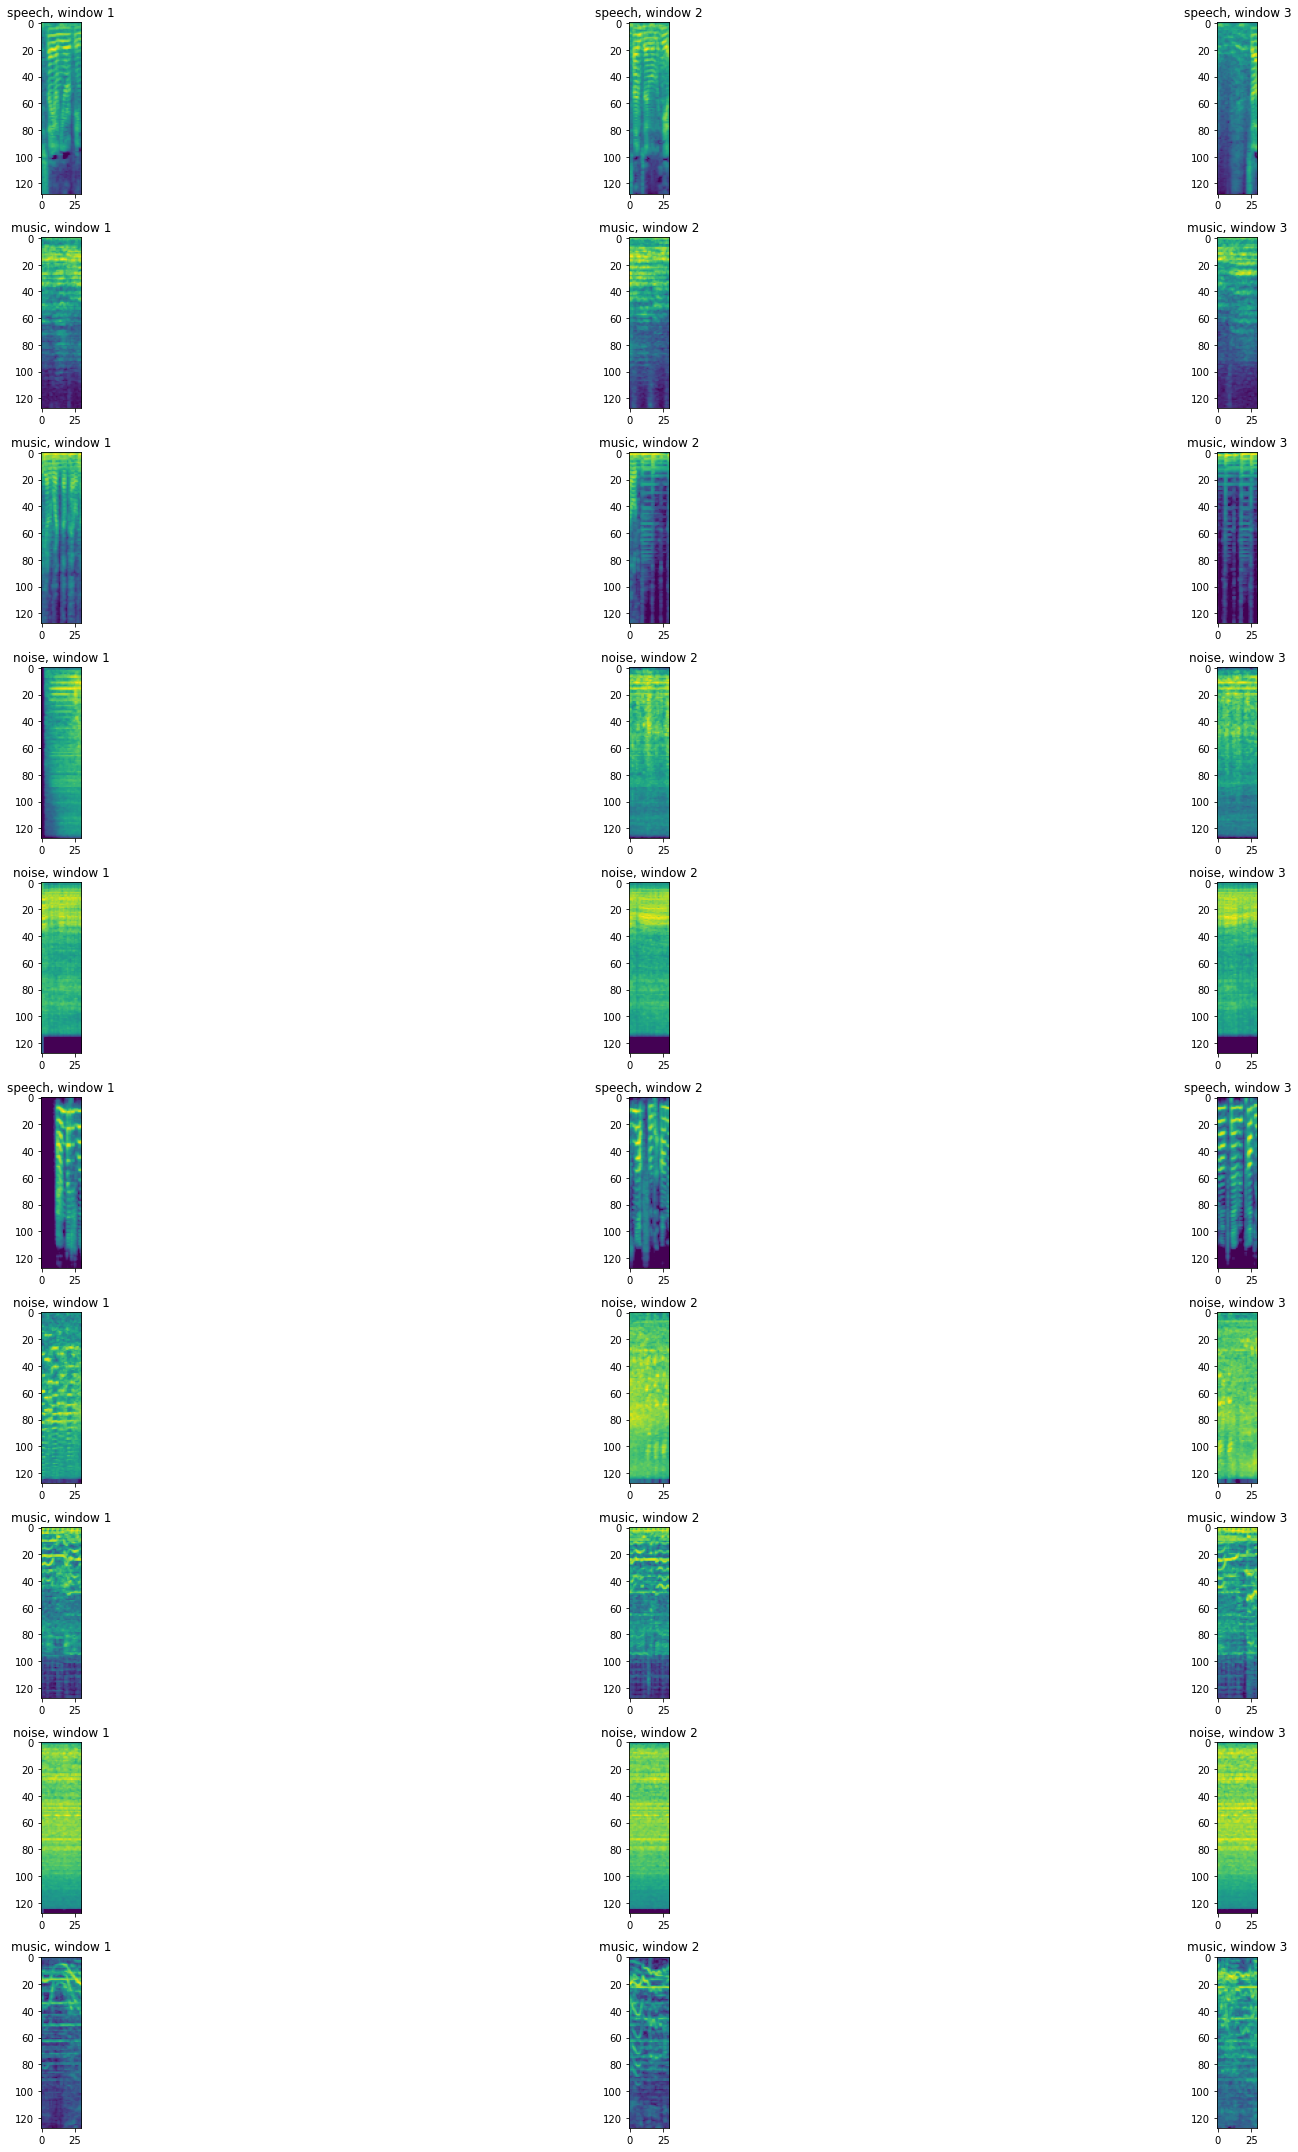

In [6]:
fig, ax = plt.subplots(10, N_CUTS, figsize=(30, 30))
for i, row in enumerate(train.sample(10).values):
    filepath, label = row[1], row[2]
    for j, window in enumerate(process_wav(ROOT_DIR, filepath)):
        ax[i, j].imshow(window.squeeze(0))
        ax[i, j].set_title(f"{label}, window {j+1}")
fig.tight_layout()
plt.show()

# Create PyTorch Datasets and DataLoaders

In [7]:
class SpecDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            target_ = torch.tensor(target).long()
            spec = process_wav(ROOT_DIR, filename, to_windows=False)
            self.data[0].append(spec)
            self.data[1].append(target_)
        
    def __getitem__(self, index):
        return self.data[0][index], self.data[1][index]
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])
    

class WindowDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            target_ = torch.tensor(target).long()
            windows = process_wav(ROOT_DIR, filename, to_windows=True)
            for window in windows:
                self.data[0].append(window)
                self.data[1].append(target_)
        
    def __getitem__(self, index):
        return self.data[0][index], self.data[1][index]
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])

In [8]:
train_dataset = WindowDataset(train)
validation_dataset = SpecDataset(val)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, drop_last=False)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, drop_last=False)

In [10]:
batch_X_train, batch_y_train = next(iter(train_dataloader))
print(type(batch_X_train), batch_X_train.shape)
print(type(batch_y_train), batch_y_train.shape)

<class 'torch.Tensor'> torch.Size([32, 1, 128, 30])
<class 'torch.Tensor'> torch.Size([32])


# Define the model

In [11]:
class SpecNet(nn.Module):
    """
    98% on spectrograms with 3 windows
    """
    def __init__(self, N, p=0.2):
        super(SpecNet, self).__init__()
        self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
        # head
        self.conv = nn.Conv2d(1, 64, 5, stride=3)
        self.batchnorm = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=7, stride=3, padding=1, dilation=1, ceil_mode=False)

        # block 1
        self.conv1_1 = nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.drop1_1 = nn.Dropout(p)
        self.batchnorm1_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_1 = nn.ReLU(inplace=True)
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.batchnorm2_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # block 2
        self.conv1_2 = nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.drop1_2 = nn.Dropout(p)
        self.batchnorm1_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_2 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.batchnorm2_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2 = nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
        self.batchnorm2_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # block 3
        self.conv1_3 = nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.drop1_3 = nn.Dropout(p)
        self.batchnorm1_3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu_3 = nn.ReLU(inplace=True)
        self.conv2_3 = nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        self.batchnorm2_3 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_3 = nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
        self.batchnorm2_3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.finalpool = nn.AdaptiveAvgPool2d(output_size=(2, 2))
        self.linear = nn.Linear(256*2*2, N, bias=False)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(self.device)
        # head
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # block 1
        x_remember = x.clone()
        x = self.conv1_1(x)
        x = self.drop1_1(x)
        x = self.batchnorm1_1(x)
        x = self.relu_1(x)
        x = self.conv2_1(x)
        x = self.batchnorm2_1(x)
        x = x + x_remember
        x = F.relu(x)

        # block 2
        x_remember = x.clone()
        x = self.conv1_2(x)
        x = self.drop1_2(x)
        x = self.batchnorm1_2(x)
        x = self.relu_2(x)
        x = self.conv2_2(x)
        x = self.batchnorm2_2(x)
        x = x + F.pad(x_remember, [0, 0, 0, 0, 32, 32, 0, 0])
        x = F.relu(x)

        # block 3
        x_remember = x.clone()
        x = self.conv1_3(x)
        x = self.drop1_3(x)
        x = self.batchnorm1_3(x)
        x = self.relu_3(x)
        x = self.conv2_3(x)
        x = self.batchnorm2_3(x)
        x = x + F.pad(x_remember, [0, 0, 0, 0, 64, 64, 0, 0])
        x = F.relu(x)

        # end
        x = self.finalpool(x)
#         print(x.shape)
        x = self.linear(x.view(batch_size, -1))
        #         x = F.log_softmax(x, dim=1)

        return x

# Create the model

In [18]:
net = SpecNet(N)
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
# net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# net.fc = nn.Linear(in_features=512, out_features=N, bias=True)
net = net.to(device)
history = []
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)
batch_X, batch_y = next(iter(train_dataloader))
out = net(batch_X)
net

SpecNet(
  (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(3, 3))
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=7, stride=3, padding=1, dilation=1, ceil_mode=False)
  (conv1_1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (drop1_1): Dropout(p=0.2, inplace=False)
  (batchnorm1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU(inplace=True)
  (conv2_1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (batchnorm2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (drop1_2): Dropout(p=0.2, inplace=False)
  (batchnorm1_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU(inplace=True)
  (

# Train and validate the model

In [19]:
def train_epoch(net, train_dataloader, optimizer, loss):
    net.train()
    loss_train = []
    
    for batch_X, batch_y_true in train_dataloader:
        batch_X = batch_X.to(device)
        batch_y_true = batch_y_true.to(device)
        out = net(batch_X)
        train_batch_loss = loss(out, batch_y_true)
        
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
        
        loss_train.append(train_batch_loss.item())

    return np.array(loss_train).mean()


def validate(net, validation_dataloader, loss):
    net.eval()
    pred = torch.tensor([]).to(device)
    true = torch.tensor([]).to(device)
    loss_val = []
    
    for batch_X, batch_y_true in validation_dataloader:
        batch_size = batch_X.size(0)
        batch_X = batch_X.to(device)
        batch_y_true = batch_y_true.to(device)
        batch_windows = spec_to_windows(batch_X, batch=True)
        batch_y_pred_windows = torch.empty(N_CUTS, batch_size).to(device)
        with torch.no_grad():
            window_losses = []
            for i, batch_window in enumerate(batch_windows):
                out = net(batch_window)
                batch_y_pred_windows[i] = out.argmax(axis=1)
                window_losses.append(loss(out, batch_y_true).item())
        batch_loss = np.array(window_losses).mean()
        batch_y_pred = torch.mode(batch_y_pred_windows, axis=0).values
        pred = torch.cat((pred, batch_y_pred))
        true = torch.cat((true, batch_y_true))
        
        loss_val.append(batch_loss)

    acc = accuracy_score(true.cpu(), pred.cpu())
    
    return acc, np.array(loss_val).mean()

In [21]:
N_EPOCHS = 500
n_val = 5

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = make_subplots(
    cols=2, rows=1,
    subplot_titles=['Loss', 'Accuracy'], column_widths=[0.7, 0.3]
    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation accuracy', row=1, col=2
)
fig_loss.update_layout(height=500, width=1300, title_text='')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp\\2d"):
        os.makedirs("models\\tmp\\2d")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        acc, loss_val = validate(net, validation_dataloader, loss)
        accs_val.append(acc)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    fig_loss.data[2].x = epochs_val
    fig_loss.data[2].y = accs_val
    
    torch.save(net.state_dict(), f"models\\tmp\\2d\\{epoch}")

FigureWidget({
    'data': [{'name': 'train loss',
              'type': 'scatter',
              'uid': '45cd…

We can choose the best model according to the maximu of validation accuracy. The model on different training epochs is saved at tmp\2d.

Cross validation is recommended to prevent overfitting to the validation set, but I don't have the resources to do that.

# Train model on full data

I haven't actually run the followind section because it would take too much time to complete.

My submission is generated by the model trained on 10% of the data. 

This section can be skipped!

In [26]:
class FullWindowsDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            self.data[0].append(filename)
            self.data[1].append(target)
        
    def __getitem__(self, index):
        return process_wav(ROOT_DIR, self.data[0][index // N_CUTS], to_windows=True)[index % N_CUTS], self.data[1][index]
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])

In [23]:
full_train_dataset = FullWindowsDataset(pd.read_csv('train.csv'))
full_train_dataloader = torch.utils.data.DataLoader(full_train_dataset, batch_size=32, drop_last=False)

In [ ]:
N_EPOCHS = 100
n_val = 3

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = make_subplots(
    cols=2, rows=1,
    subplot_titles=['Loss', 'Accuracy'], column_widths=[0.7, 0.3]
    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation accuracy', row=1, col=2
)
fig_loss.update_layout(height=500, width=1300, title_text='')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp"):
        os.makedirs("models\\tmp")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(net, full_train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        acc, loss_val = validate(net, validation_dataloader, loss)
        accs_val.append(acc)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    fig_loss.data[2].x = epochs_val
    fig_loss.data[2].y = accs_val
    
    torch.save(net.state_dict(), f"models\\tmp\\{epoch}")

# Make submission

In [27]:
submit_features = pd.read_csv('sample_submission.csv')
submit_features.head()

,wav_path,target
0,val/e/b7cf2c4.wav,0
1,val/0/8f1489d.wav,0
2,val/f/14b7304.wav,0
3,val/2/3763132.wav,0
4,val/0/51c4271.wav,0


In [28]:
class SubmissionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = []
        for filename in tqdm(data["wav_path"], total=len(data)):
            self.data.append(filename)
        
    def __getitem__(self, index):
        return process_wav(ROOT_DIR, self.data[index], to_windows=False), self.data[index]
    
    def __len__(self):
        return len(self.data)

In [29]:
submission_dataset = SubmissionDataset(submit_features)
submission_dataloader = torch.utils.data.DataLoader(submission_dataset, batch_size=32, drop_last=False, num_workers=0)

Input "y" to generate a submission.

In [30]:
if input() == 'y':
    submission = pd.DataFrame(columns=['wav_path', 'target'])
    submission.to_csv('submission.csv', index=False)

 n


In [ ]:
net.eval()
for batch_X, batch_wav_path in tqdm(submission_dataloader):
    batch_size = batch_X.size(0)
    batch_X = batch_X.to(device)
    with torch.no_grad():
        batch_windows = spec_to_windows(batch_X, batch=True)
        batch_y_pred_windows = torch.empty(N_CUTS, batch_size).to(device)
        for i, batch_window in enumerate(batch_windows):
            out = net(batch_window)
            batch_y_pred_windows[i] = out.argmax(axis=1)
        batch_y_pred = torch.mode(batch_y_pred_windows, axis=0).values.cpu().numpy().astype(int)
        batch_submission = pd.DataFrame({'wav_path': batch_wav_path, 'target': batch_y_pred})
        batch_submission.to_csv('submission.csv', mode='a', index=False, header=False)

The submission is saved as `submission.csv`